In [312]:
# libs
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
from datetime import datetime
import os
from tqdm import tqdm  # Import the tqdm function to visualize the progress of the loop

# bar plots
import matplotlib.pyplot as plt
import seaborn as sns

# TradingView (Data Load)

In [313]:
# today's date string for file namine automation
# today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
today_date_str = '_2024-02-29.csv'
print(today_date_str)

_2024-02-29.csv


In [314]:
# cocncat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"

# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

1968 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month
0,MSFT,Microsoft Corporation,NASDAQ,3044619688433.315,USD,409.7498,USD,405.99,USD,0.93,USD,0.228098,-0.424311,7318946247.799999,2839299,47051756,126056,17741826.8,22830385.26666667,25291348.41111112,0.609457,1.195507,1.502454,409.231600,37.05895973,Technology Services,1.06078968,0.95424896,1.0329885,0.8991026,0.003111,0.6152751,2.06775164,4.64372452,1.93620062,1.14503216,0.45399198,0.14561989,0.44358748,0.76596883
1,NVDA,NVIDIA Corporation,NASDAQ,1990875012516.9575,USD,796.3500,USD,773.10,USD,14.31,USD,1.842576,-0.454528,2399390000,9707640,138586477,819885,53908983.1,50323442.26666665,45061053.10000012,2.850368,3.399679,3.657460,795.189967,66.71553638,Electronic Technology,0.89580438,1.7775623,2.2734668,1.6840769,0.001124,0.24948078,2.21813941,4.1161605,2.01894127,1.01006685,0.32218449,0.16740949,0.6319595,1.0997833
2,GOOG,Alphabet Inc.,NASDAQ,1730044155537.2178,USD,139.7300,USD,137.01,USD,0.96,USD,0.698537,-0.305610,5277727492,3939287,90444981,164652,21170203.89999997,22578360.00000004,22311163.86666668,1.825293,1.883917,1.881561,139.246667,24.06979949,Technology Services,1.24235988,1.0578916,1.2103225,1.0635216,0.002806,0.20531851,0.92141598,1.77117077,1.02981769,0.60892544,0.33176544,0.17553615,0.94797939,0.92173886
3,GOOGL,Alphabet Inc.,NASDAQ,1729639569627.8755,USD,138.6300,USD,135.92,USD,0.94,USD,0.689251,-0.337293,5871219472,6190380,130259923,276293,29425635.50000001,31398104.20000001,29860686.23333333,1.810087,1.922204,1.925504,138.166667,23.8803142,Technology Services,1.15164986,1.0654415,1.1954733,1.0578468,0.005767,0.23959501,1.29224337,2.49291023,1.27724181,0.68223387,0.36264381,0.19919481,1.00569294,0.97416549
4,META,"Meta Platforms, Inc.",NASDAQ,1248571203261.7717,USD,489.7500,USD,483.74,USD,4.23,USD,0.873931,-0.057849,2193139642.9500003,1807004,37433500,79165,15596302,20764694.03333334,18969553.86666667,1.209528,1.657961,2.415497,488.596667,32.87729168,Technology Services,0.66955888,1.3402786,1.0570395,1.1544267,0.003306,0.49012763,1.3069932,3.05118543,1.27639357,0.79314904,0.28605413,0.10566384,0.42064,1.02485917


In [315]:
# # first 10 rows df
# trading_view_raw_df_testing = trading_view_raw_df.head(10)
# # save to csv
# trading_view_raw_df_testing.to_csv('trading_view_raw_data/tv_screen_gap-up_testing.csv', index=False)
# # make sure data is there at least
# print(len(trading_view_raw_df_testing.index))

# # print test df
# trading_view_raw_df_testing

In [316]:
# # baseline raw cols from trading view initial filter
# features_raw_all = trading_view_raw_df.columns
# # convert to list
# features_raw_all = features_raw_all.tolist()
# # look at the trading view columns
# print(features_raw_all)

In [317]:
"""
define function -> add new column and marketCapType based on 'Market capitalization' column

criteria (6 groupings):
200B and above = 'Titans' - 1
10B to 200B = 'Large caps' - 2
2B to 10B = 'Midlers' - 3
300M to 2B = 'Small caps' - 4
300m and below = 'Micro caps' - 5
50m and below = 'Shrimp' - 6

"""

"\ndefine function -> add new column and marketCapType based on 'Market capitalization' column\n\ncriteria (6 groupings):\n200B and above = 'Titans' - 1\n10B to 200B = 'Large caps' - 2\n2B to 10B = 'Midlers' - 3\n300M to 2B = 'Small caps' - 4\n300m and below = 'Micro caps' - 5\n50m and below = 'Shrimp' - 6\n\n"

In [318]:
def categorize_market_cap(df):
    # Convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    
    # Define the conditions for each market cap category using regular number notation
    conditions = [
        # Titans
        (df['Market capitalization'] >= 200000000000),  # 200 billion and above
        #Large Cap
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),  # 10 billion to 200 billion
        # Midlers
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),  # 2 billion to 10 billion
        # Small Cap
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000),  # 300 million to 2 billion
        # Micro Cap
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),  # 300 million and below (excluding 50 million and below)
        # Shrimp
        (df['Market capitalization'] <= 50000000)  # 50 million and below
    ]
    
    # Define the category names corresponding to each condition
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    
    # Use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df


In [319]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,marketCapType
0,MSFT,Microsoft Corporation,NASDAQ,3.044620e+12,USD,409.7498,USD,405.99,USD,0.93,USD,0.228098,-0.424311,7318946247.799999,2839299,47051756,126056,17741826.8,22830385.26666667,25291348.41111112,0.609457,1.195507,1.502454,409.231600,37.05895973,Technology Services,1.06078968,0.95424896,1.0329885,0.8991026,0.003111,0.6152751,2.06775164,4.64372452,1.93620062,1.14503216,0.45399198,0.14561989,0.44358748,0.76596883,Titans
1,NVDA,NVIDIA Corporation,NASDAQ,1.990875e+12,USD,796.3500,USD,773.10,USD,14.31,USD,1.842576,-0.454528,2399390000,9707640,138586477,819885,53908983.1,50323442.26666665,45061053.10000012,2.850368,3.399679,3.657460,795.189967,66.71553638,Electronic Technology,0.89580438,1.7775623,2.2734668,1.6840769,0.001124,0.24948078,2.21813941,4.1161605,2.01894127,1.01006685,0.32218449,0.16740949,0.6319595,1.0997833,Titans
2,GOOG,Alphabet Inc.,NASDAQ,1.730044e+12,USD,139.7300,USD,137.01,USD,0.96,USD,0.698537,-0.305610,5277727492,3939287,90444981,164652,21170203.89999997,22578360.00000004,22311163.86666668,1.825293,1.883917,1.881561,139.246667,24.06979949,Technology Services,1.24235988,1.0578916,1.2103225,1.0635216,0.002806,0.20531851,0.92141598,1.77117077,1.02981769,0.60892544,0.33176544,0.17553615,0.94797939,0.92173886,Titans
3,GOOGL,Alphabet Inc.,NASDAQ,1.729640e+12,USD,138.6300,USD,135.92,USD,0.94,USD,0.689251,-0.337293,5871219472,6190380,130259923,276293,29425635.50000001,31398104.20000001,29860686.23333333,1.810087,1.922204,1.925504,138.166667,23.8803142,Technology Services,1.15164986,1.0654415,1.1954733,1.0578468,0.005767,0.23959501,1.29224337,2.49291023,1.27724181,0.68223387,0.36264381,0.19919481,1.00569294,0.97416549,Titans
4,META,"Meta Platforms, Inc.",NASDAQ,1.248571e+12,USD,489.7500,USD,483.74,USD,4.23,USD,0.873931,-0.057849,2193139642.9500003,1807004,37433500,79165,15596302,20764694.03333334,18969553.86666667,1.209528,1.657961,2.415497,488.596667,32.87729168,Technology Services,0.66955888,1.3402786,1.0570395,1.1544267,0.003306,0.49012763,1.3069932,3.05118543,1.27639357,0.79314904,0.28605413,0.10566384,0.42064,1.02485917,Titans


In [320]:
# # check for NaNs
# print(trading_view_raw_df.isna().sum())

In [321]:
# drop NaNs
tv_df = trading_view_raw_df.dropna()
# get simple count of NaNs total. should be 0
print(f'NaNs = {tv_df.isna().sum().sum()}')

# if there are no NaNs, print "No NaNs in DataFrame! Success!", else print the NaN count and "There are x NaNs in DataFrame, check your code dumb dumb!"
if tv_df.isna().sum().sum() == 0:
    nan_count = tv_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {tv_df.isna().sum().sum()} NaNs in DataFrame, check your code dumb dumb!")


NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [322]:
mc_groups = trading_view_raw_df['marketCapType'].value_counts().reset_index()
mc_groups.columns = ['marketCapType', 'count']  # Rename columns for clarity

# Calculate percentage for each market cap type and add it to the DataFrame
mc_groups['percentage'] = (mc_groups['count'] / mc_groups['count'].sum()) * 100

# print total "there are etc."
print(f'There are still the same {len(trading_view_raw_df.index)} U.S. Stocks in the dataframe \n$(pre-market change) > $0.00 USD')
# Display the enhanced DataFrame
mc_groups

There are still the same 1968 U.S. Stocks in the dataframe 
$(pre-market change) > $0.00 USD


,marketCapType,count,percentage
0,Small caps,485,24.644309
1,Midlers,466,23.678862
2,Large caps,426,21.646341
3,Shrimp,291,14.786585
4,Micro caps,254,12.906504
5,Titans,27,1.371951
6,Undefined,19,0.965447


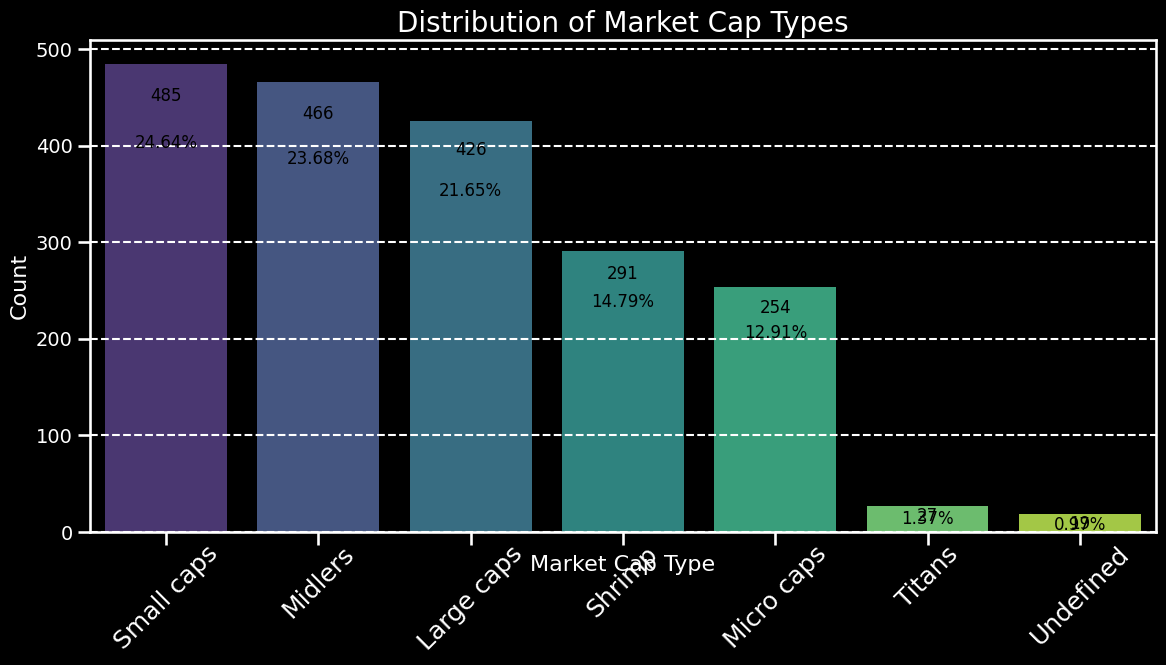

In [323]:
# Set dark mode for plotting
plt.style.use('dark_background')
sns.set_context('talk')  # Larger fonts and figures

# Create a bar chart
plt.figure(figsize=(12, 7))
barplot = sns.barplot(data=mc_groups, x='marketCapType', y='count', hue='marketCapType', palette='viridis', dodge=False)

# Disable the legend
plt.legend([],[], frameon=False)

# Customize the plot with count and percentage labels inside the bars
for index, row in mc_groups.iterrows():
    # Calculate the position for the count and percentage text to be inside the bar
    height = row['count']
    offset = height * 0.05  # Offset from the top of the bar for better visibility
    
    # Display the count inside the bar at the top
    barplot.text(index, height - offset, f'{row["count"]}', color='black', ha="center", va="top", fontsize=12)
    
    # Display the percentage just below the count, inside the bar
    # Adjust the vertical position slightly below the count
    percentage_offset = height * 0.15  # Adjust this value as needed to fit inside the bar
    barplot.text(index, height - percentage_offset, f'{row["percentage"]:.2f}%', color='black', ha="center", va="top", fontsize=12)

# Add marketCapType labels underneath the bars
for index, row in mc_groups.iterrows():
    barplot.text(index, -10, row['marketCapType'], color='white', ha="center", va="top", rotation=45)

plt.title('Distribution of Market Cap Types', fontsize=20, color='white')
plt.xlabel('Market Cap Type', fontsize=16, color='white')
plt.ylabel('Count', fontsize=16, color='white')
plt.xticks(rotation=45, fontsize=14, color='white')
plt.yticks(fontsize=14, color='white')

# Remove x-axis labels to avoid redundancy
barplot.set_xticklabels([])

# Show the plot
plt.tight_layout()
plt.show()


In [324]:
# print length of df
print(f'{len(tv_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
# print sample head
tv_df.sample(5)

1949 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,marketCapType
1573,FTII,FutureTech II Acquisition Corp.,NASDAQ,9.443112e+07,USD,11.2000,USD,11.1100,USD,0.1000,USD,0.892857,-0.803571,5611907.62,3251,7485,813,10088.6,50393.56666667,41702.87777778,1.696429,1.229812,0.405201,11.263333,55.17241379,Finance,-,-0.00863745,-0.00021849,-0.00021849,0.097943,0.20624227,0.13923698,0.13417716,0.13298757,0.13298757,0.29225221,0.32167735,0.04004968,0.8354206,Micro caps
1906,CISS,C3is Inc.,NASDAQ,3.065738e+06,USD,0.1083,USD,0.1024,USD,0.0017,USD,1.644101,-0.967118,27435958.528,660607,8750534,138946,2952909.5,17024278.46666667,6048992.57777778,6.226415,6.819338,8.756124,0.108100,-,Transportation,1.50352121,-0.21982285,1.966321,1.966321,0.016152,0.00878309,3.25636912,4.62943233,2.10318391,1.24198294,0.50208047,0.20653927,0.17206451,-,Shrimp
485,S,"SentinelOne, Inc.",NYSE,8.703383e+09,USD,29.1400,USD,28.1200,USD,0.4100,USD,1.452870,-0.354359,228656970,881423,12767745,33668,4549584.5,5101837.46666667,5852693.81111111,3.255163,3.284065,3.957520,28.953333,-,Technology Services,1.28153197,1.6697379,0.7038514,0.7038514,0.003378,0.48362999,1.58300089,2.24368859,1.52296159,1.09669033,0.47729936,0.17014348,0.49079761,0.67695505,Midlers
1710,INKT,"MiNK Therapeutics, Inc.",NASDAQ,3.348395e+07,USD,0.9700,USD,1.0000,USD,0.0095,USD,1.000000,5.263158,9835963.20806,3924,111389,400,39368.3,51126.26666667,46872.77777778,5.123608,4.623334,7.608805,0.979900,-,Health Technology,-,1.6398973,0.0268633,0.0268633,2.910887,2.35985688,1.65596062,0.8231958,0.45701422,0.33212823,0.17824579,0.08961625,0.40510689,0.52729675,Shrimp
384,CFG,"Citizens Financial Group, Inc.",NYSE,1.446460e+10,USD,31.5300,USD,30.7500,USD,0.4200,USD,1.366298,0.032531,455429635.479,508005,13248158,10043,4113975.4,5742492.06666667,5599537.98888889,3.050355,2.274875,3.093203,31.398333,10.13077146,Finance,1.65035052,1.9831922,0.96892565,1.376632,0.006733,0.24013451,1.28363114,3.01081729,1.39793921,0.6890933,0.34584618,0.11058057,0.52002304,0.83963872,Large caps


In [325]:
# show unique values for 'marketCapType'
print(tv_df['marketCapType'].unique())
print()
# get tv_df columns
print(tv_df.columns)

['Titans' 'Large caps' 'Midlers' 'Small caps' 'Micro caps' 'Shrimp']

Index(['Symbol', 'Description', 'Exchange', 'Market capitalization',
       'Market capitalization - Currency', 'Price', 'Price - Currency',
       'Pre-market Open', 'Pre-market Open - Currency', 'Pre-market Change',
       'Pre-market Change - Currency', 'Pre-market Change %',
       'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day',
       'Volume 1 week', 'Pre-market Volume', 'Average Volume 10 days',
       'Average Volume 30 days', 'Average Volume 90 days', 'Volatility 1 day',
       'Volatility 1 week', 'Volatility 1 month',
       'Volume Weighted Average Price 1 day', 'Price to earnings ratio',
       'Sector', 'Relative Volume at Time', 'Beta 1 year', 'Beta 3 years',
       'Beta 5 years', 'Relative Volume 1 minute', 'Relative Volume 5 minutes',
       'Relative Volume 15 minutes', 'Relative Volume 30 minutes',
       'Relative Volume 1 hour', 'Relative Volume 2 hours',
       'Relative Volume 

In [326]:
# drop undefined
tv_df = tv_df[tv_df['marketCapType'] != 'Undefined']

mc_groups2 = tv_df['marketCapType'].value_counts().reset_index()
mc_groups2.columns = ['marketCapType', 'count']  # Rename columns for clarity

# calculate percentage for each market cap type and add it to the DataFrame
mc_groups2['percentage'] = (mc_groups2['count'] / mc_groups2['count'].sum()) * 100

mc_groups2
print(mc_groups2)


  marketCapType  count  percentage
0    Small caps    485   24.884556
1       Midlers    466   23.909697
2    Large caps    426   21.857363
3        Shrimp    291   14.930734
4    Micro caps    254   13.032324
5        Titans     27    1.385326


In [327]:
# 1/3 #### CONFIG DATA SECTION ####
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # Reduced to 0.2% for Titans
        "float_shares_outstanding_threshold": 1000000000,  # Increased to 1 billion shares
        "relative_volume_threshold": 1.2,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.03,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.001,  # Reduced to 0.1%
        "pre_market_vmap_drawdown_threshold": 0.003  # .3% drawdown from VWAP
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # Reduced to 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # Increased to 200 million shares
        "relative_volume_threshold": 1.3,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # Reduced to 0.5%
        "pre_market_vmap_drawdown_threshold": 0.004  # .4% drawdown from VWAP
    },
    "Midlers": {
        "pre_market_change_pct_threshold": 0.02,  # 2% for Mid caps
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .02,
        "pre_market_vmap_drawdown_threshold": 0.005  # .5% drawdown from VWAP
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .03,
        "pre_market_vmap_drawdown_threshold": 0.006  # 6% drawdown from VWAP
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .04,
        "pre_market_vmap_drawdown_threshold": 0.007  # 7% drawdown from VWAP
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .05,
        "pre_market_vmap_drawdown_threshold": 0.008  # 8% drawdown from VWAP
    }
}

# 2/3 #### CORE FUNCTIONS ####
def filter_by_pre_market_change(df, change_pct_threshold):
    """Filter stocks by pre-market change percentage."""
    return df[df['Pre-market Change %'] >= change_pct_threshold]

def filter_by_float_shares(df, float_shares_threshold):
    """Filter stocks by float shares outstanding."""
    # create a copy to safely modify without affecting the original DataFrame
    modified_df = df.copy()
    modified_df['Float shares outstanding'] = pd.to_numeric(modified_df['Float shares outstanding'], errors='coerce')
    return modified_df[modified_df['Float shares outstanding'] <= float_shares_threshold]

def filter_by_relative_volume(df, relative_volume_threshold):
    """Filter stocks by relative volume."""
    df['Relative Volume 1 day'] = pd.to_numeric(df['Relative Volume 1 day'], errors='coerce')
    return df[df['Relative Volume 1 day'] >= relative_volume_threshold]

def filter_by_relative_volume_at_time(df, relative_volume_at_time_threshold):
    """Filter stocks by relative volume at a specific time."""
    # Convert 'Relative Volume at Time' to float
    df['Relative Volume at Time'] = pd.to_numeric(df['Relative Volume at Time'], errors='coerce')
    return df[df['Relative Volume at Time'] >= relative_volume_at_time_threshold]

def filter_by_pre_market_gap_percentage(df, pre_market_gap_percentage_threshold):
    """Filter stocks by pre-market gap percentage."""
    return df[df['Pre-market Gap %'] >= pre_market_gap_percentage_threshold]

def filter_by_price_near_vwap(df, pre_market_vmap_drawdown_threshold):
    """
    Filter stocks where the price is near the VWAP, considering the specified drawdown threshold.
    """
    df_filtered = df.copy()
    df_filtered['Price'] = pd.to_numeric(df_filtered['Price'], errors='coerce')
    df_filtered['Volume Weighted Average Price 1 day'] = pd.to_numeric(df_filtered['Volume Weighted Average Price 1 day'], errors='coerce')
    
    # Calculate the acceptable minimum price based on the VWAP drawdown threshold
    df_filtered['Min Price from VWAP'] = df_filtered['Volume Weighted Average Price 1 day'] * (1 - pre_market_vmap_drawdown_threshold)
    
    # Apply the filter
    df_filtered = df_filtered[df_filtered['Price'] >= df_filtered['Min Price from VWAP']]
    
    return df_filtered.drop(columns=['Min Price from VWAP'])

"""SPECIAL FILTERS"""
def filter_by_volatility(df):
    """Filter stocks based on recent volatility being higher than weekly and monthly averages."""
    # Ensure data types are correct; convert to numeric if necessary
    df['Volatility 1 day'] = pd.to_numeric(df['Volatility 1 day'], errors='coerce')
    df['Volatility 1 week'] = pd.to_numeric(df['Volatility 1 week'], errors='coerce')
    df['Volatility 1 month'] = pd.to_numeric(df['Volatility 1 month'], errors='coerce')
    filtered_df = df[
        (df['Volatility 1 day'] >= df['Volatility 1 week']) & 
        (df['Volatility 1 day'] >= df['Volatility 1 month'])]
    return filtered_df

# def filter_by_price_above_vwap(df):
#     """Filter stocks where the price is greater than the VWAP 1 day."""
#     # Ensure data types are correct; convert to numeric if necessary
#     df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
#     df['Volume Weighted Average Price 1 day'] = pd.to_numeric(df['Volume Weighted Average Price 1 day'], errors='coerce')
    
#     # Apply the filter
#     filtered_df = df[df['Price'] > df['Volume Weighted Average Price 1 day']]
#     return filtered_df

# 3/3 #### WRAPPER FUNCTION ####
def screen_stocks_by_category(df, category):
    """Screen stocks based on their market cap category."""
    # 3a. Get the configuration for the specified category
    config = criteria_config.get(category, {})
    pre_market_change_pct_threshold = config.get("pre_market_change_pct_threshold", 0)
    float_shares_threshold = config.get("float_shares_outstanding_threshold", float('inf'))
    relative_volume_threshold = config.get("relative_volume_threshold", 0)
    relative_volume_at_time_threshold = config.get("relative_volume_at_time_threshold", 0)
    pre_market_gap_percentage_threshold = config.get("pre_market_gap_percentage_threshold", 0)
    pre_market_vmap_drawdown_threshold = config.get("pre_market_vmap_drawdown_threshold", 0)
    # 3b. Apply the filters
    filtered_df = filter_by_pre_market_change(df, pre_market_change_pct_threshold)
    filtered_df = filter_by_float_shares(filtered_df, float_shares_threshold)
    filtered_df = filter_by_relative_volume(filtered_df, relative_volume_threshold)
    filtered_df = filter_by_relative_volume_at_time(filtered_df, relative_volume_at_time_threshold)
    filtered_df = filter_by_volatility(filtered_df) # SPECIAL FILTER
    # filtered_df = filter_by_price_above_vwap(filtered_df) # SPECIAL FILTER
    filtered_df = filter_by_pre_market_gap_percentage(filtered_df, pre_market_gap_percentage_threshold)
    filtered_df = filter_by_price_near_vwap(filtered_df, pre_market_vmap_drawdown_threshold)
  
    # 3c. Return the filtered DataFrame
    return filtered_df

In [328]:
#EXECUTE
tv_L2_df = pd.DataFrame()
categories = tv_df['marketCapType'].unique()

for category in categories:
    category_df = tv_df[tv_df['marketCapType'] == category]
    screened_df = screen_stocks_by_category(category_df, category)
    tv_L2_df = pd.concat([tv_L2_df, screened_df])

# Display results
print(f'Original DataFrame length: {len(tv_df.index)}')
print(f'Number of rows removed: {len(tv_df.index) - len(tv_L2_df.index)}')
print(f'NEW DataFrame length: {len(tv_L2_df.index)}')
print()
print(tv_L2_df.columns)

# filter in descending order by market cap and then by pre-market change percentage
tv_L2_df = tv_L2_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
# reset index and drop
tv_L2_df = tv_L2_df.reset_index(drop=True)
# display head
display(tv_L2_df.head(20))

Original DataFrame length: 1949
Number of rows removed: 1945
NEW DataFrame length: 4

Index(['Symbol', 'Description', 'Exchange', 'Market capitalization',
       'Market capitalization - Currency', 'Price', 'Price - Currency',
       'Pre-market Open', 'Pre-market Open - Currency', 'Pre-market Change',
       'Pre-market Change - Currency', 'Pre-market Change %',
       'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day',
       'Volume 1 week', 'Pre-market Volume', 'Average Volume 10 days',
       'Average Volume 30 days', 'Average Volume 90 days', 'Volatility 1 day',
       'Volatility 1 week', 'Volatility 1 month',
       'Volume Weighted Average Price 1 day', 'Price to earnings ratio',
       'Sector', 'Relative Volume at Time', 'Beta 1 year', 'Beta 3 years',
       'Beta 5 years', 'Relative Volume 1 minute', 'Relative Volume 5 minutes',
       'Relative Volume 15 minutes', 'Relative Volume 30 minutes',
       'Relative Volume 1 hour', 'Relative Volume 2 hours',
       '

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,marketCapType
0,OKTA,"Okta, Inc.",NASDAQ,1.827761e+10,USD,110.5420,USD,107.07,USD,20.65,USD,23.654066,22.646048,1.552757e+08,5239002,15308969,379806,2810526,1992399.06666667,2557038.34444444,23.597753,4.397763,3.766420,109.210667,-,Technology Services,23.042682,1.6754102,0.8932449,0.93737215,0.000994,0.49127958,3.02616643,17.65235778,10.74339088,8.33095705,5.3002582,2.047812,1.85452922,0.85578511,Large caps
1,DUOL,"Duolingo, Inc.",NASDAQ,9.844751e+09,USD,234.1550,USD,237.00,USD,44.49,USD,22.755869,21.221421,3.515839e+07,1062142,4582882,41043,738991.1,622052.73333333,693110.36666667,20.391980,5.407077,4.152326,232.291667,-,Technology Services,16.843683,2.2356162,0.72150964,0.72150964,0.009749,0.24704312,1.66495137,17.16535868,8.13997292,5.0288557,3.36720831,1.555617,1.86261149,0.98818719,Midlers
2,ITRN,Ituran Location and Control Ltd.,NASDAQ,5.517771e+08,USD,27.4400,USD,26.25,USD,0.60,USD,2.318393,1.429675,1.350434e+07,63780,227291,1402,43777.8,44632.73333333,58217.54444444,7.037037,2.289132,2.374918,27.406667,12.09236735,Communications,14.715658,0.5316182,0.6634075,1.1739424,0.935810,13.96440512,13.60559876,22.46231156,11.10559006,6.41276131,4.10121605,1.576898,1.10316747,0.82242826,Small caps
3,VLCN,"Volcon, Inc.",NASDAQ,5.728348e+05,USD,2.0099,USD,1.69,USD,0.62,USD,51.239669,39.669421,2.531638e+05,51686518,79193119,19734498,9181164,3805609.40148148,1421682.48938272,60.000000,37.014971,31.584649,1.953300,-,Consumer Durables,130.795005,0.0323214,-0.4841484,-0.4841484,0.000102,0.66010323,5.15708493,22.10465939,14.47586526,13.2759791,11.60136632,11.340839,17.08027322,69.76105782,Shrimp


In [329]:
# create a breakdown of the market cap types
mc_groups3 = tv_L2_df['marketCapType'].value_counts().reset_index()
mc_groups3.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage for each market cap type and add it to the DataFrame
mc_groups3['percentage'] = (mc_groups3['count'] / mc_groups3['count'].sum()) * 100
# Display the enhanced DataFrame
print(mc_groups3)

  marketCapType  count  percentage
0    Large caps      1        25.0
1       Midlers      1        25.0
2    Small caps      1        25.0
3        Shrimp      1        25.0


In [330]:
print(tv_L2_df.columns)
print(len(tv_L2_df.columns))

Index(['Symbol', 'Description', 'Exchange', 'Market capitalization',
       'Market capitalization - Currency', 'Price', 'Price - Currency',
       'Pre-market Open', 'Pre-market Open - Currency', 'Pre-market Change',
       'Pre-market Change - Currency', 'Pre-market Change %',
       'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day',
       'Volume 1 week', 'Pre-market Volume', 'Average Volume 10 days',
       'Average Volume 30 days', 'Average Volume 90 days', 'Volatility 1 day',
       'Volatility 1 week', 'Volatility 1 month',
       'Volume Weighted Average Price 1 day', 'Price to earnings ratio',
       'Sector', 'Relative Volume at Time', 'Beta 1 year', 'Beta 3 years',
       'Beta 5 years', 'Relative Volume 1 minute', 'Relative Volume 5 minutes',
       'Relative Volume 15 minutes', 'Relative Volume 30 minutes',
       'Relative Volume 1 hour', 'Relative Volume 2 hours',
       'Relative Volume 4 hours', 'Relative Volume 1 day',
       'Relative Volume 1 week', 'R

In [331]:
# slice of first 12 columns
tv_L2_df.iloc[:, :12]

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %
0,OKTA,"Okta, Inc.",NASDAQ,1.827761e+10,USD,110.5420,USD,107.07,USD,20.65,USD,23.654066
1,DUOL,"Duolingo, Inc.",NASDAQ,9.844751e+09,USD,234.1550,USD,237.00,USD,44.49,USD,22.755869
2,ITRN,Ituran Location and Control Ltd.,NASDAQ,5.517771e+08,USD,27.4400,USD,26.25,USD,0.60,USD,2.318393
3,VLCN,"Volcon, Inc.",NASDAQ,5.728348e+05,USD,2.0099,USD,1.69,USD,0.62,USD,51.239669


In [332]:
# import mplfinance as mpf
# df['SMA20'] = df['Close'].rolling(window=20).mean()

# # Define additional plot parameters for SMAs and Bollinger Bands
# sma = mpf.make_addplot(df['SMA20'], color='blue', width=1.5)

# # Plot the candlestick chart with SMA overlay
# mpf.plot(df, type='candle', addplot=sma, volume=True, style='yahoo', figsize=(10, 6), title='Stock Price with SMA Overlay')


In [333]:
# # look at relative volume 1 day
# tv_L2_df.loc[:, ['Symbol','Description', 'Relative Volume 1 day']]

In [334]:
# print(len(tv_L2_df.index))
# tv_L2_df.loc[tv_L2_df['Relative Volume 1 day'] >= 1.0]


In [335]:
# sort descending by change %
# another df and  / or chart market cap representations

# i think you need to go back and filter this shit down more
# chart could be nice to reference, really just need something i can see easy while working

# re-index this shit and keep it clean
# don't be a dumbass and have any data leakage

# you can do a lot more with changes on different very short term time frames

# do i need a calculation for pre-market price????

# you need to figure out implied volatility and noise vs. signal.

# volume vs time avg current >= avg over each time 10,20,30 day etc
# volatility vs time avg >= avg over each time like above

# discretionary tax type of thing that accounts for industry sector implied volatility????
# or might be counterproductive to gap up strategy anyway...

In [336]:
# get that historical data. worry later about grabbing the levels.
# 90 days (1 quarter)
# then look at the 52 and 26 week high and lows. and other common levels 12 week? those are all other potential ket levels
# similar levels to the downside + kill switches, i.e., at loss >= $1000 || 10% below VWAP
# 252 / 4 = 63 trading days per quarter

# IEX Cloud (API)

In [337]:
from datetime import datetime, timedelta
from dotenv import load_dotenv
import requests 

# $ecret shit
load_dotenv()
# iex api key load using python-dotenv lib (pip3 install pythone-dotenv)
iex_key = os.getenv("IEX_API_KEY")

In [338]:
# create a list of 'Symbols' from the tv_L2_df
gap_up_stocks_list = tv_L2_df['Symbol']
gap_up_stocks_list = gap_up_stocks_list.tolist()

# print data
gap_up_stocks_list

['OKTA', 'DUOL', 'ITRN', 'VLCN']

In [339]:
# # STRIVE funds (Vivek)
# strive_funds_list = ['STRV', # Strive 500 ETF
#                      'STXG', # Strive 1000 Growth ETF
#                      'STXV', # Strive 1000 Value ETF
#                      'STXK', # Strive Small-Cap ETF
#                      'STXD', # Strive 1000 Divident Growth ETF
#                      'STXE', # Strive Emerging Markets Ex-China ETF
#                      'DRLL', # Strive U.S. Energy ETF
#                      'SHOC', # Strive U.S. Semiconductor ETF
#                      'FTWO', # Strive FANG 2.0 ETF
#                      'STXT', # Strive Total Return Bond ETF
#                      'BUXX'] # Strive Enhanced Income Short Maturity ETF

In [340]:
# index_baseline_list = [
#     'VOO',  # Vanguard S&P 500 ETF
#     'VGT',  # Vanguard Information Technology ETF
#     'VTWO', # Vanguard Russell 2000 ETF
#     'VEA',  # Vanguard Developed Markets Index Fund
#     'VWO',  # Vanguard Emerging Markets Stock Index Fund
#     'BND',  # Vanguard Total Bond Market ETF
#     'VT',   # Vanguard Total World Stock ETF
#     'VNQ',  # Vanguard Real Estate ETF
#     'VCR',  # Vanguard Consumer Discretionary ETF
#     'IWV',  # iShares Russell 3000 ETF
#     'VYM',  # Vanguard High Dividend Yield ETF
#     'XLK',  # Technology Select Sector SPDR Fund
#     'GLD',  # SPDR Gold Shares
#     'IGF',  # iShares Global Infrastructure ETF
#     'ICLN', # iShares Global Clean Energy ETF
#     'EEM',  # iShares MSCI Emerging Markets ETF
#     'BNDX', # Vanguard Total International Bond ETF
#     'XLV',  # Health Care Select Sector SPDR Fund
#     'XLP'   # Consumer Staples Select Sector SPDR Fund
# ]

In [341]:
# manual add list
manual_add_list = [
    'DELL',
    'PLTR',
    'TSLA'
]

gap_up_stocks_list.extend(manual_add_list)

In [342]:
# baseline S&P 500 indexes for market correlation
sp_indexes_list = ['STRV', # not sure which one to go with or if it matters????
                   'VOO',
                   'SPY']

# extend the dataframe in place (append)
gap_up_stocks_list.extend(sp_indexes_list)

# # vivek's funds and some of the baseline indexes
# gap_up_stocks_list.extend(strive_funds_list)
# gap_up_stocks_list.extend(index_baseline_list)

# view data
gap_up_stocks_list

['OKTA', 'DUOL', 'ITRN', 'VLCN', 'DELL', 'PLTR', 'TSLA', 'STRV', 'VOO', 'SPY']

In [343]:
import requests
import pandas as pd
from tqdm import tqdm

# Your existing setup
symbols = ','.join(gap_up_stocks_list)

# SETTING THE DATE RANGE
"""
y - Example: range=1y -> returns (one year)
ytd - Example: range=ytd -> returns (year-to-date)
m - Example: range=6m returns (six months)
d - Example: range=5d returns (five days)
"""
data_range = '6m' 

url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={symbols}&types=chart&range={data_range}&token={iex_key}'

# Make the GET request
response = requests.get(url)

# Initialize a list to collect DataFrames for each symbol
dataframes_list = []

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()

    # Process and print the data with a progress bar
    for symbol in tqdm(gap_up_stocks_list, desc="Processing symbols"):
        if symbol in data:
            # Create a DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(data[symbol]['chart'])
            # Add a 'Ticker' column to identify the data
            symbol_df['Ticker'] = symbol
            # Append the current symbol's DataFrame to the list
            dataframes_list.append(symbol_df)
            # print(f'Data for {symbol}:')
            # print(symbol_df.head(5))  # print the first few rows of the DataFrame for this symbol
else:
    print(f'Failed to fetch data: {response.status_code}')

# Concatenate all DataFrames in the list to create a single combined DataFrame
historical_data_super_df = pd.concat(dataframes_list, ignore_index=True)

# Now `historical_data_super_df` contains all the data
historical_data_super_df.head()


Processing symbols: 100%|██████████| 10/10 [00:00<00:00, 1179.67it/s]


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
0,87.17,88.8255,85.270,85.28,2023-09-05,OKTA,4684316.0,HISTORICAL_PRICES,OKTA,,2023-09-05,1693962028000,0.000000,0.000000,85.28,87.17,88.8255,85.270,4684316,85.28,87.17,88.8255,85.270,4684316.0,"Sep 5, 23",0.00,0.0000,OKTA
1,87.50,88.1500,86.245,86.51,2023-09-06,OKTA,3512844.0,HISTORICAL_PRICES,OKTA,,2023-09-06,1694048490000,0.003786,0.003786,86.51,87.50,88.1500,86.245,3512844,86.51,87.50,88.1500,86.245,3512844.0,"Sep 6, 23",0.33,0.0038,OKTA
2,87.68,88.8000,86.230,86.53,2023-09-07,OKTA,2509223.0,HISTORICAL_PRICES,OKTA,,2023-09-07,1694134847000,0.005851,0.005851,86.53,87.68,88.8000,86.230,2509223,86.53,87.68,88.8000,86.230,2509223.0,"Sep 7, 23",0.18,0.0021,OKTA
3,87.38,88.3199,86.542,87.60,2023-09-08,OKTA,1655902.0,HISTORICAL_PRICES,OKTA,,2023-09-08,1694233848000,0.002409,0.002409,87.60,87.38,88.3199,86.542,1655902,87.60,87.38,88.3199,86.542,1655902.0,"Sep 8, 23",-0.30,-0.0034,OKTA
4,90.08,90.7296,87.520,87.52,2023-09-11,OKTA,2528941.0,HISTORICAL_PRICES,OKTA,,2023-09-11,1694480458000,0.033383,0.033383,87.52,90.08,90.7296,87.520,2528941,87.52,90.08,90.7296,87.520,2528941.0,"Sep 11, 23",2.70,0.0309,OKTA


In [344]:
print(len(historical_data_super_df.index))
print(historical_data_super_df['Ticker'].value_counts())

1240
Ticker
OKTA    124
DUOL    124
ITRN    124
VLCN    124
DELL    124
PLTR    124
TSLA    124
STRV    124
VOO     124
SPY     124
Name: count, dtype: int64


In [345]:
print(len(historical_data_super_df.index))
print(historical_data_super_df.columns)
historical_data_super_df.sample(5)

1240
Index(['close', 'high', 'low', 'open', 'priceDate', 'symbol', 'volume', 'id',
       'key', 'subkey', 'date', 'updated', 'changeOverTime',
       'marketChangeOverTime', 'uOpen', 'uClose', 'uHigh', 'uLow', 'uVolume',
       'fOpen', 'fClose', 'fHigh', 'fLow', 'fVolume', 'label', 'change',
       'changePercent', 'Ticker'],
      dtype='object')


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
951,30.12,30.26,30.0906,30.23,2024-01-03,STRV,100691.0,HISTORICAL_PRICES,STRV,,2024-01-03,1704333637000,0.046560,0.046560,30.23,30.12,30.26,30.0906,100691,30.23,30.12,30.26,30.0906,100691.0,"Jan 3, 24",-0.250,-0.0082,STRV
486,1.21,1.28,1.0300,1.15,2024-02-16,VLCN,3678828.0,HISTORICAL_PRICES,VLCN,,2024-02-16,1708137073000,-0.486418,-0.486418,1.15,1.21,1.28,1.0300,3678828,1.15,1.21,1.28,1.0300,3678828.0,"Feb 16, 24",0.105,0.0950,VLCN
710,16.76,17.06,16.6200,16.68,2024-01-12,PLTR,33952550.0,HISTORICAL_PRICES,PLTR,,2024-01-12,1705113060000,0.101907,0.101907,16.68,16.76,17.06,16.6200,33952550,16.68,16.76,17.06,16.6200,33952550.0,"Jan 12, 24",0.080,0.0048,PLTR
839,208.80,217.80,206.2700,212.26,2024-01-22,TSLA,117952527.0,HISTORICAL_PRICES,TSLA,,2024-01-22,1705980853000,-0.185933,-0.185933,212.26,208.80,217.80,206.2700,117952527,212.26,208.80,217.80,206.2700,117952527.0,"Jan 22, 24",-3.390,-0.0160,TSLA
18,81.51,83.89,80.9100,82.37,2023-09-29,OKTA,2279465.0,HISTORICAL_PRICES,OKTA,,2023-09-29,1696037437000,-0.064931,-0.064931,82.37,81.51,83.89,80.9100,2279465,82.37,81.51,83.89,80.9100,2279465.0,"Sep 29, 23",0.050,0.0006,OKTA


In [346]:
# new df with columns ['date', 'close', 'priceDate','uClose']
yahoo_format_iex_data_cols = ['date', 'symbol','close']
yahoo_format_iex_data_df = historical_data_super_df[yahoo_format_iex_data_cols]

# check to make sure you are pulling all the symbols
unique_symbols_list = yahoo_format_iex_data_df['symbol'].unique()
print(f'Unique stock ticker symbols: {unique_symbols_list}')
print(f'Length BEFORE multi-indexing: {len(yahoo_format_iex_data_df)}')
# yahoo_format_iex_data_df.sample(10)
# print(f'Data Head: {yahoo_format_iex_data_df.head(2)}')
# print(f'Data Tail: {yahoo_format_iex_data_df.tail(2)}')
# print(yahoo_format_iex_data_df.head(2))
# print(yahoo_format_iex_data_df.tail(2))

# save the df to csv
yahoo_format_iex_data_df.to_csv('yahoo_format_iex_data_df.csv', index=False)

# view data 
yahoo_format_iex_data_df.tail(10)

Unique stock ticker symbols: ['OKTA' 'DUOL' 'ITRN' 'VLCN' 'DELL' 'PLTR' 'TSLA' 'STRV' 'VOO' 'SPY']
Length BEFORE multi-indexing: 1240


,date,symbol,close
1230,2024-02-16,SPY,499.51
1231,2024-02-20,SPY,496.76
1232,2024-02-21,SPY,497.21
1233,2024-02-22,SPY,507.50
1234,2024-02-23,SPY,507.85
1235,2024-02-26,SPY,505.99
1236,2024-02-27,SPY,506.93
1237,2024-02-28,SPY,506.26
1238,2024-02-29,SPY,508.08
1239,2024-03-01,SPY,512.85


In [347]:
# set the multiIndex with 'date' and 'symbol' as the index columns
yahoo_format_iex_data_df.set_index(['date', 'symbol'], inplace=True)
# sort the multi-index
sorted_yahoo_format_iex_data_df = yahoo_format_iex_data_df.sort_index()
# unstack the 'symbol' level of the index to pivot it into column headers
yahoo_iex_df = sorted_yahoo_format_iex_data_df.unstack(level='symbol')

# view the iex data with the applied multi-index view (like how yahoo finance sends it but more data)
print(f'{len(yahoo_iex_df)} Trading Periods (daily) -> with MULTI-INDEX')
print(f'Start Date: {yahoo_iex_df.index.min()}')
print(f'End Date: {yahoo_iex_df.index.max()}')
print()

# view iex data in yahoo multi-index format
print('IEX Data in Yahoo Multi-Index Format')
yahoo_iex_df.head()

124 Trading Periods (daily) -> with MULTI-INDEX
Start Date: 2023-09-05
End Date: 2024-03-01

IEX Data in Yahoo Multi-Index Format


close                                                              \
symbol       DELL    DUOL   ITRN   OKTA   PLTR     SPY   STRV    TSLA    VLCN   
date                                                                            
2023-09-05  68.10  153.94  30.21  87.17  15.21  449.24  28.78  256.49  2.3560   
2023-09-06  70.47  155.01  30.12  87.50  15.30  446.22  28.59  251.92  2.3700   
2023-09-07  68.98  156.22  30.13  87.68  15.21  444.85  28.51  251.49  2.6355   
2023-09-08  70.50  156.51  29.46  87.38  15.13  445.52  28.56  248.50  2.5035   
2023-09-11  72.16  161.38  29.40  90.08  15.79  448.45  28.76  273.58  2.9390   

                    
symbol         VOO  
date                
2023-09-05  412.90  
2023-09-06  410.05  
2023-09-07  408.83  
2023-09-08  409.39  
2023-09-11  412.08

In [348]:
"""
mplfinance library testing

Testing objective:
- create a simple candlestick chart with volume for one stock (PLTR)

Overall (short-term) objective:
- create a simple candlestick chart with volume for multiple stocks (LATER)
- i am thinking individual charts for each stock in a grid layout and focused layout for each stock also.
- on thos charts I am going to have the historical price and then at least the 4 (SMA) + 6(Bollinger Band lines across)
I am going to start here and if i can get this done then break.
"""

import mplfinance as mpf


In [349]:
# # DEV - save iex historical data to csv (sample)
# historical_data_super_df_2_csv = historical_data_super_df.sample(50)
# historical_data_super_df_2_csv.to_csv('historical_data_super_df_sample_50.csv')

In [350]:
##### KEY LEVELS ####
print(f'{len(historical_data_super_df)} Rows of Historical Data')
# print how many unique priceDate values there are (essentially a cross reference check against the number of days)
print(f"{len(historical_data_super_df['date'].unique())} Unique Trading Days (i.e., trading days in your {data_range} IEX API range setting)")

historical_data_super_df.head(5)

1240 Rows of Historical Data
124 Unique Trading Days (i.e., trading days in your 6m IEX API range setting)


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
0,87.17,88.8255,85.270,85.28,2023-09-05,OKTA,4684316.0,HISTORICAL_PRICES,OKTA,,2023-09-05,1693962028000,0.000000,0.000000,85.28,87.17,88.8255,85.270,4684316,85.28,87.17,88.8255,85.270,4684316.0,"Sep 5, 23",0.00,0.0000,OKTA
1,87.50,88.1500,86.245,86.51,2023-09-06,OKTA,3512844.0,HISTORICAL_PRICES,OKTA,,2023-09-06,1694048490000,0.003786,0.003786,86.51,87.50,88.1500,86.245,3512844,86.51,87.50,88.1500,86.245,3512844.0,"Sep 6, 23",0.33,0.0038,OKTA
2,87.68,88.8000,86.230,86.53,2023-09-07,OKTA,2509223.0,HISTORICAL_PRICES,OKTA,,2023-09-07,1694134847000,0.005851,0.005851,86.53,87.68,88.8000,86.230,2509223,86.53,87.68,88.8000,86.230,2509223.0,"Sep 7, 23",0.18,0.0021,OKTA
3,87.38,88.3199,86.542,87.60,2023-09-08,OKTA,1655902.0,HISTORICAL_PRICES,OKTA,,2023-09-08,1694233848000,0.002409,0.002409,87.60,87.38,88.3199,86.542,1655902,87.60,87.38,88.3199,86.542,1655902.0,"Sep 8, 23",-0.30,-0.0034,OKTA
4,90.08,90.7296,87.520,87.52,2023-09-11,OKTA,2528941.0,HISTORICAL_PRICES,OKTA,,2023-09-11,1694480458000,0.033383,0.033383,87.52,90.08,90.7296,87.520,2528941,87.52,90.08,90.7296,87.520,2528941.0,"Sep 11, 23",2.70,0.0309,OKTA


In [351]:
# print cols
print(historical_data_super_df.columns)

Index(['close', 'high', 'low', 'open', 'priceDate', 'symbol', 'volume', 'id',
       'key', 'subkey', 'date', 'updated', 'changeOverTime',
       'marketChangeOverTime', 'uOpen', 'uClose', 'uHigh', 'uLow', 'uVolume',
       'fOpen', 'fClose', 'fHigh', 'fLow', 'fVolume', 'label', 'change',
       'changePercent', 'Ticker'],
      dtype='object')


In [352]:
# DEV - NaNs check
print(len(historical_data_super_df.index))
# drop rows that have NaNs
historical_data_super_df = historical_data_super_df.dropna()
print(len(historical_data_super_df.index))

1240
1240


In [353]:
# get mandatory cols for a historical ($price) bar chart + volume (IMPORTANT - *MANDATORY cols are REQUIRED for the required operation)
key_levels_df = historical_data_super_df[['symbol', # *MANDATORY
                                               'date', # *MANDATORY
                                               'close', # *MANDATORY
                                               'high', # *MANDATORY
                                               'low', # *MANDATORY
                                               'open', # *MANDATORY
                                               'volume']] # *MANDATORY
                      

key_levels_df.head(5)

,symbol,date,close,high,low,open,volume
0,OKTA,2023-09-05,87.17,88.8255,85.270,85.28,4684316.0
1,OKTA,2023-09-06,87.50,88.1500,86.245,86.51,3512844.0
2,OKTA,2023-09-07,87.68,88.8000,86.230,86.53,2509223.0
3,OKTA,2023-09-08,87.38,88.3199,86.542,87.60,1655902.0
4,OKTA,2023-09-11,90.08,90.7296,87.520,87.52,2528941.0


# DELL FOCUS - Pre-market

In [354]:
# $DELL
dell_df = key_levels_df[key_levels_df['symbol'] == 'DELL'].copy()
dell_df['date'] = pd.to_datetime(dell_df['date'])
dell_df.set_index('date', inplace=True)
dell_df.head(5)

,symbol,close,high,low,open,volume
date,,,,,,
2023-09-05,DELL,68.10,69.8300,67.54,68.05,9466373.0
2023-09-06,DELL,70.47,70.4800,67.83,68.00,7585616.0
2023-09-07,DELL,68.98,70.6197,68.57,69.47,7649325.0
2023-09-08,DELL,70.50,70.8900,69.09,69.37,5550484.0
2023-09-11,DELL,72.16,72.8200,70.56,71.12,7449202.0


In [355]:
# # EXAMPLE CHART - candlestick chart and volume only NO key level support and resistance yet
# mc = mpf.make_marketcolors(up='green', down='red', inherit=True)
# s  = mpf.make_mpf_style(base_mpf_style='nightclouds', marketcolors=mc)
# fig, axlist = mpf.plot(dell_df, type='candle', style=s, volume=True,
#                        returnfig=True, title='DELL Candlestick Chart', figratio=(15, 8))
# bg_color = fig.get_facecolor()
# fig.text(0.5, 0.5, '$'+'DELL', fontsize=40, color='#ffffff', alpha=0.3,
#          ha='center', va='center', rotation='horizontal')
# #show
# mpf.show()

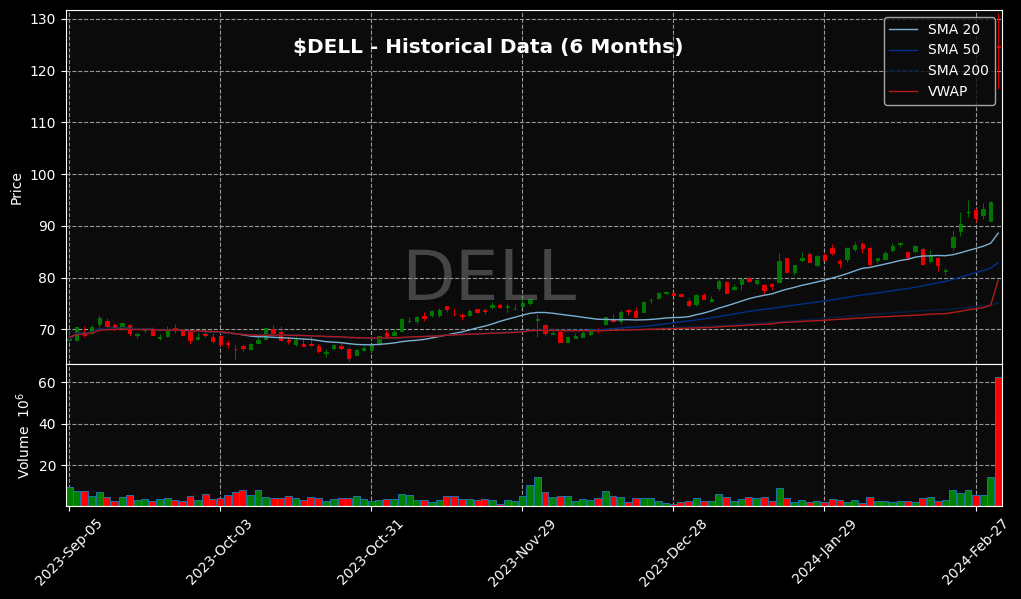

In [356]:
import mplfinance as mpf
# candlestick chart
# MANDATORY DATA = 'open', 'high', 'low', 'close', 'volume'

"""
Part 1:    
"""
# Part 1a: SMAs -> calculate
dell_df['SMA20'] = dell_df['close'].rolling(window=20, min_periods=1).mean()
dell_df['SMA50'] = dell_df['close'].rolling(window=50, min_periods=1).mean()
dell_df['SMA200'] = dell_df['close'].rolling(window=200, min_periods=1).mean()

# Part 1b: VWAP -> calculate
dell_df['VWAP'] = (dell_df['volume'] * (dell_df['high'] + dell_df['low'] + dell_df['close']) / 3).cumsum() / dell_df['volume'].cumsum()

"""   
Part 2: 
"""
add2plot = [
    #### SMAs ####
    mpf.make_addplot(dell_df['SMA20'], color='#7BAFD4', width=1.0, label='SMA 20'), # UNC blue
    mpf.make_addplot(dell_df['SMA50'], color='#003087', width=1.0, label='SMA 50'), # DUKE blue
    mpf.make_addplot(dell_df['SMA200'], color='#041E42', width=1.0, label='SMA 200'), # HOYAS blue
    #### VWAP ####
    mpf.make_addplot(dell_df['VWAP'], color='#B31B1B', width=1.0, label='VWAP') # BIG RED
]

"""   
Part 3: styling not iterative changes related to data (i.e., color, font, etc.)
"""
# Use a dark theme style and set text color to white
mpf_style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={'text.color': 'white'})

# Plot the candlestick chart with the moving averages
fig, axes = mpf.plot(dell_df,
                     type='candle',
                     addplot=add2plot,
                     volume=True,
                    #  style=mpf_style,
                     style=s, 
                     # WTF look at docs (it's not erroring out but going to default style just figure out what that is i think)
                     figratio=(15, 8),
                     title='$DELL - Historical Data (6 Months)',
                     tight_layout=True,
                     returnfig=True)

# Add a watermark if needed
fig.text(0.5, 0.5, 'DELL', fontsize=50, color='gray', alpha=0.5, ha='center', va='center', rotation=0, transform=fig.transFigure)

plt.show()


In [357]:
dell_df.head(5)

,symbol,close,high,low,open,volume,SMA20,SMA50,SMA200,VWAP
date,,,,,,,,,,
2023-09-05,DELL,68.10,69.8300,67.54,68.05,9466373.0,68.100000,68.100000,68.100000,68.490000
2023-09-06,DELL,70.47,70.4800,67.83,68.00,7585616.0,69.285000,69.285000,69.285000,68.980820
2023-09-07,DELL,68.98,70.6197,68.57,69.47,7649325.0,69.183333,69.183333,69.183333,69.107501
2023-09-08,DELL,70.50,70.8900,69.09,69.37,5550484.0,69.512500,69.512500,69.512500,69.300610
2023-09-11,DELL,72.16,72.8200,70.56,71.12,7449202.0,70.042000,70.042000,70.042000,69.803676


In [358]:
""" 
ISSUE: some weird shit with the style param
nbd tho ctfo. 

workaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  
the blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style
experienced similar shit like this years ago, idunno will get to it.

"""

' \nISSUE: some weird shit with the style param\nnbd tho ctfo. \n\nworkaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  \nthe blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style\nexperienced similar shit like this years ago, idunno will get to it.\n\n'

In [359]:
# you're going to need different charts, one for the pre-market, and at least another for market open
# I'd like market opens to be a live feed but really we might already be in trading view watching the pine script execute

| END OF IN PROGRESS WORK - NOTES BELOW |
|--|

In [360]:
# but first start with getting lines on that chart with STRV
# let's get those key levels with an output on them and figure out your strategy
# figure out when fibonacci extensions get activated
# i see one view with a grid layout of the stock charts above or below them the summary with the key levels, current price and all that
# i also see a view where when looking at individiual stocks we got data all over that shit. idgaf if it's "confusing for the user"

# you have your key_levels_df
# so start next from there okay

#### </b> ####

# make title more symetrically bigger not just bigger for fucks sake 
# move price to the right side, keep vol on left
# see if you can get a marker or military like custom google font one of the ones you like
# better yet use that program you wrote for sn logos actually to create your shit
# could put that Sans Peur Systems somewhere at least watermark it, maybe?
# key levels find up to 6?, scoring strategy?, then base allotment of position (1/3, 1/5) conditionally?
# we could add RSI down there, fuck could add ichimoku, do whatever with all this data access now

NOTES -> SMA Legend

In [361]:
# # SMA20, SMA50, and SMA200 has to be in 'dell_df'
# legend_info = {
#     'Indicator': ['SMA20', 'SMA50', 'SMA200'],
#     'Color': ['blue', 'orange', 'green'],
#     'Description': ['20-day Moving Average', '50-day Moving Average', '200-day Moving Average']
# }

# legend_df = pd.DataFrame(legend_info)
# print(legend_df)


NOTES -> custom mplfinance chart setup example

In [362]:
# """    
# Custom Theme setup
# """

# dark_style = mpf.make_mpf_style(base_mpf_style='charles', 
#                                 rc={'axes.facecolor': 'black',
#                                     'figure.facecolor': 'darkslategrey',
#                                     'axes.grid': True,
#                                     'grid.color': 'gray',
#                                     'grid.linestyle': '--',
#                                     'grid.linewidth': 0.6,
#                                     'axes.titlesize': 16,
#                                     'axes.titleweight': 'bold',
#                                     'axes.labelsize': 12,
#                                     'axes.labelweight': 'bold',
#                                     'axes.labelcolor': 'white',
#                                     'axes.edgecolor': 'white',
#                                     'axes.linewidth': 2,
#                                     'xtick.color': 'white',
#                                     'xtick.labelsize': 10,
#                                     'ytick.color': 'white',
#                                     'ytick.labelsize': 10,
#                                     'figure.titlesize': 18,
#                                     'figure.titleweight': 'bold',
#                                     'legend.facecolor': 'grey',
#                                     'legend.edgecolor': 'white',
#                                     'legend.fontsize': 10,
#                                     'legend.title_fontsize': 12})

# mpf.plot(strv_df, 
#          type='candle', 
#          style=dark_style,  # Using the custom dark style
#          volume=True, 
#          title='STRV Candlestick Chart',
#          mav=(20, 50, 200),  # Adding moving averages of 20, 50, and 200 periods
#          figratio=(15, 8), 
#          tight_layout=True)

In [363]:
# i need a math checker for trading days vs calendar days (252/365)

Notes -> yahoo finance API exaple (free) *with limitations

In [364]:
# import yfinance as yf
# from datetime import datetime, timedelta

In [365]:
# # yahoo finance data download
# start = datetime.now() - timedelta(days=60)
# end = datetime.now()
# yahoo_df = yf.download(gap_up_stocks_list, start, end)
# yahoo_df = yahoo_df.loc[:,'Close']
# # view the yahoo data yahoo finance formatting multi-index (has a 60day max with standard API maneuvers)
# yahoo_df.head(10)